In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os

In [2]:
datadir = '../Diagnostics/Data/Measurements/2022-06-23/'
os.listdir(datadir)

['220623133741-longemittance.h5']

In [3]:
filename = '220623133741-longemittance'
datafile = filename+'.h5'



In [4]:
f = h5py.File(datadir+datafile, 'r')
ds = f['/scandata']

dt = ds.dtype
attrs = dt.names

print(attrs)



('timestamp', 'iteration', 'cam08y', 'slowQ', 'sat08', 'int08', 'magnet_CurrentRb', 'magnet_CurrentSet', 'phase_Readback', 'phase_Set')


/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


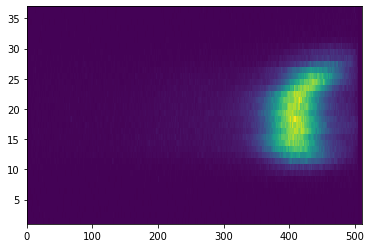

In [5]:
pixels = np.arange(len(ds[0,'cam08y']))
ts = ds[:,'iteration']
plt.pcolor(pixels,ts,ds[:,'cam08y'])

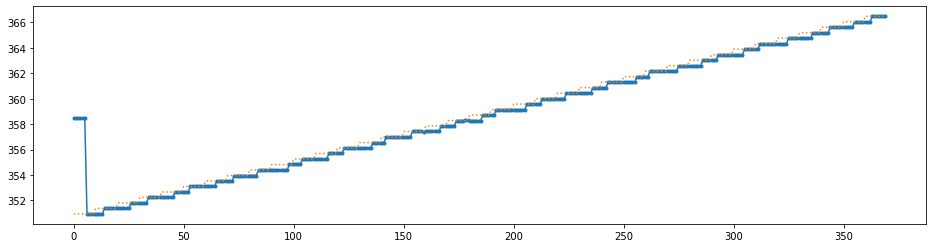

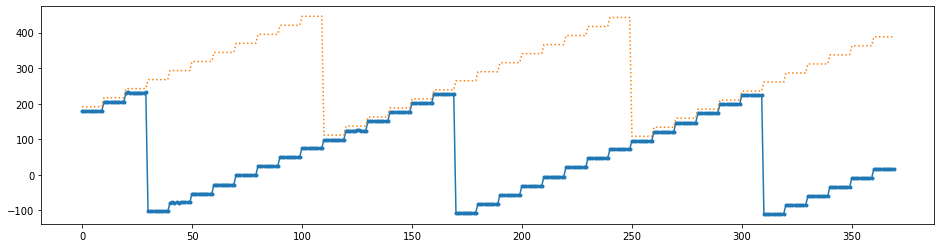

In [6]:
plt.figure(figsize=[16,4])

plt.plot(ds[:,'magnet_CurrentRb'],'.-');
plt.plot(ds[:,'magnet_CurrentSet'],':'); 

plt.figure(figsize=[16,4])
plt.plot(62-ds[:,'phase_Readback'],'.-');
plt.plot(ds[:,'phase_Set'],':');




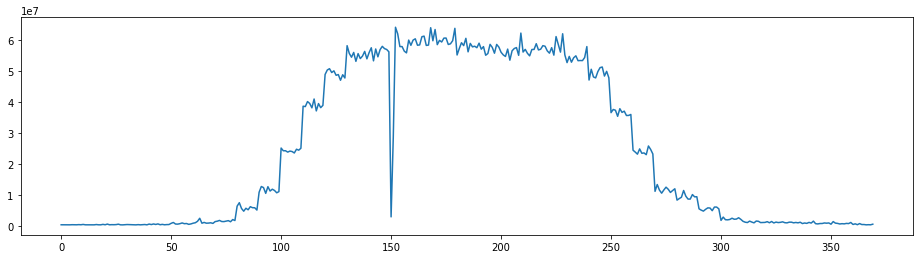

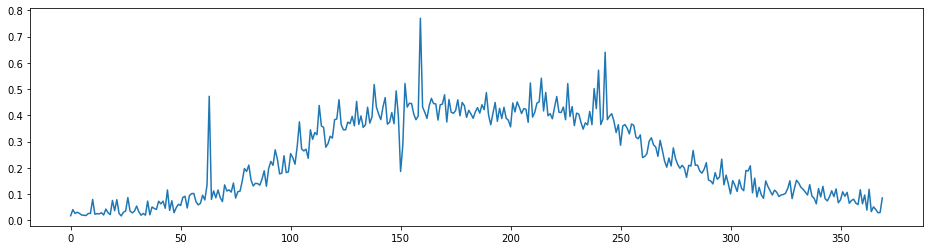

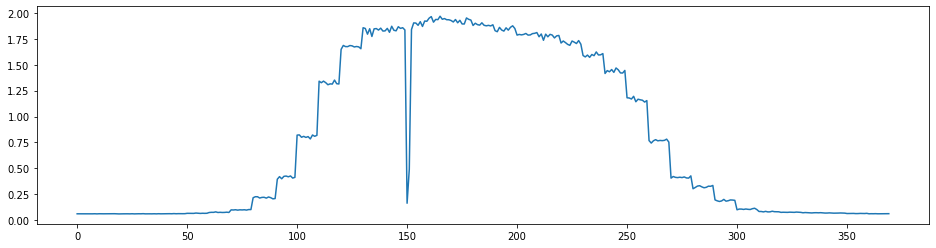

In [7]:
# -- get maximum pixel in each shot
immax = ds[:,'cam08y'].max(axis=1) 

plt.figure(figsize=[16,4])
plt.plot(immax)

plt.figure(figsize=[16,4])
plt.plot(ds[:,'sat08'])

plt.figure(figsize=[16,4])
plt.plot(ds[:,'int08'])

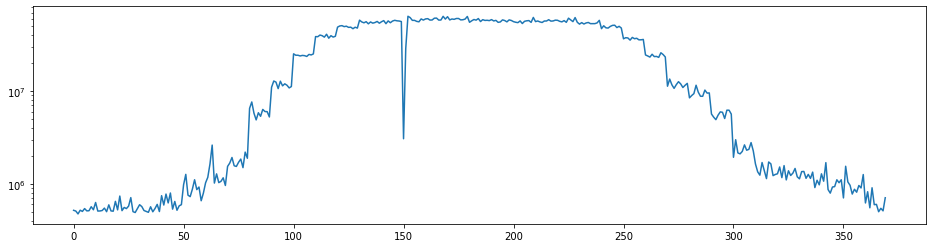

In [8]:

plt.figure(figsize=[16,4])
plt.semilogy(immax)

Est dynamic range 10^-1.807


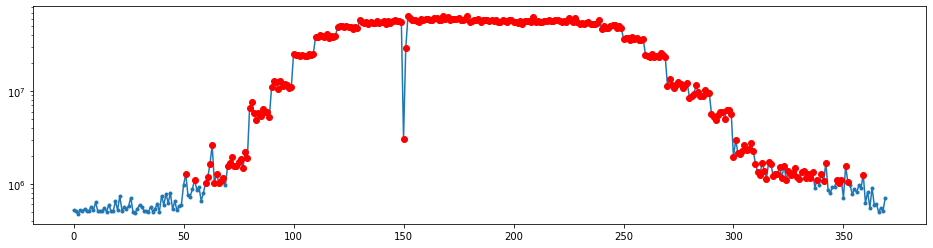

In [9]:

w = immax.copy()

thr = 1.0e6
w[w<thr] = 0

plt.figure(figsize=[16,4])
plt.semilogy(immax,'.-')
plt.semilogy(w,'or')

print('Est dynamic range 10^%.3f'%np.log10(thr / max(w)))




### Frame with peak signal

scan used 156590.73% of range, 64123904/40950


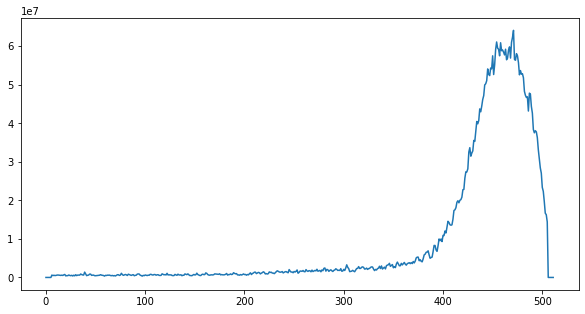

In [10]:
idx = np.argmax(w)
profy = ds[idx,'cam08y']

plt.figure(figsize=[10,5]);
plt.plot(profy)

pix_max = max(profy)
print('scan used %.2f%% of range, %i/40950'%(100.*pix_max/40950,pix_max))

In [11]:
### make list of coordinates that have signal.

idx, = np.where(w>0)
signalpts = pts[idx,:]


NameError: name 'pts' is not defined

In [ ]:

ndim = 4
M = np.identity(ndim)
M[0,1] = 0.5
M[2,3] = 0.7

# -- xp
d1_center = 13.5
d1_distance = 10
d1_steps = 20

# -- x
d2_center = 13.5
d2_distance = 13
d2_steps = 26

# -- y
d4_center = 15.
d4_distance = 20
d4_steps = 20

# -- yp
d3_center = 17.8
d3_distance = 6
d3_steps = 18


# goal steps: [17,12,27,11], stepsize between 0.73 and 0.81 mm, expected ~ 13 hours



# Get rep rate -- will set slit speed in sweep scan
reprate = 5

#
navg = 0

center = np.array([d1_center, d2_center, d3_center, d4_center])
distance = np.array([d1_distance,d2_distance, d3_distance,d4_distance])
nsteps = np.array([d1_steps, d2_steps, d3_steps,d4_steps])
stepsize = distance / nsteps

stepsize

In [ ]:
def gen(): 

    
    
    
    start = center -0.5*distance
    taking_step = [False,]*ndim
    step_counter = [0,]*ndim

    # -- if sweeper scan, adjust step parameters for first actuator
    if navg == 0: 
        sweep_speed = stepsize[0]*reprate
        stepsize[0] = distance[0]
        nsteps[0] = 1

    # -- scan is complete after <npoints> steps
    npoints = 1
    for i in range(ndim):
        npoints *= (nsteps[i]  +1 )

    # start loop
    taking_step[0] = True
    counter = 0
    lastpoint = start
    while counter < npoints:
        # print('%i / %i, %.1f%%'%(counter,npoints,counter*100./npoints))

        # -- send actuators to starting point
        # -- this is only needed for stepper scan
        if (counter == 0) & (navg > 0):
            # -- cast int sheared frame first:
            counter += 1
            nextactpoint = np.matmul(M,lastpoint - center) + center
            cmd = list(nextactpoint)     
            yield cmd, navg

        counter += 1
        thisstep = [0,]*ndim
        for i in range(ndim):
            # -- if end of line has been reached
            if step_counter[i] >= nsteps[i]:
                # -- stop stepping this actuator
                taking_step[i] = False
                # -- and make sure the next actuator knows it's time to step
                taking_step[int(np.mod(i+1,ndim))] = True
                # -- and roll over the stepcounter
                step_counter[i] = np.mod(step_counter[i],nsteps[i])
                # -- while also reversing direction of step
                stepsize[i] *= -1
            # -- if end of line has not been reached
            elif taking_step[i]:
                # -- take the next assigned step
                thisstep[i] += stepsize[i]
                # -- add one to step_counter
                step_counter[i] += 1

                # -- now that a step has been taken, stop until your turn comes up again 
                # unless you're the first actuator; that guy always steps
                if i > 0:
                    taking_step[i] = False
                    taking_step[0] = True

            # -- exit loop if an actuator has stepped
            if thisstep[i] != 0:
                break


        # -- get startpoint in actuator coordinates
        startactpoint = np.matmul(M,lastpoint - center) + center
        # -- progress 1 step
        lastpoint = lastpoint + thisstep
        # -- cast into actuator coordinates (sheared frame)
        nextactpoint = np.matmul(M,lastpoint - center) + center

        ##### STEPPER SCAN COMMAND
        if navg > 0:
            cmd = list(nextactpoint)
            yield cmd ,navg

        ##### SWEEPER SCAN COMMAND
        elif navg == 0: 
            # -- skip step if sweeper is not moving
            if thisstep[0] == 0:
                continue
            # -- send command if sweeper is moving on this step
            else: 
                cmd = []
                # -- sweeper command
                cmd.append((startactpoint[0],nextactpoint[0],sweep_speed))
                # -- commands for the rest of the actuators
                for j in range(1,ndim):
                    # if slope, stepper may have to sweep as well
                    stepper_speed = sweep_speed * np.abs(nextactpoint[j] - startactpoint[j]) / d1_distance
                    cmd.append((startactpoint[j],nextactpoint[j],stepper_speed))
            lastcmd = cmd.copy() # -- copy command in case it needs repeated
            yield cmd


In [ ]:
# -- run points generator
genpts = np.array(list(gen()))

# -- re-arrange array
newpts = np.zeros([np.shape(genpts)[0]*2,ndim])
for i in range(ndim):
    newpts[:,i] = genpts[:,i,0:2].flatten()

    
# plt.figure(figsize=[12,12])
# plt.subplot(221)
# plt.plot(newpts[:,0],newpts[:,1],'.')

# plt.subplot(222)
# plt.plot(newpts[:,3],newpts[:,2],'.')

# plt.subplot(223)
# plt.plot(newpts[:,0],newpts[:,2],'.')

# plt.subplot(224)
# plt.plot(newpts[:,1],newpts[:,3],'.')

# -- un-shear new (generated) pts
Minv = np.linalg.inv(M)
newpts_n = np.zeros(np.shape(newpts))
for row in range(np.shape(newpts)[0]):
    newpts_n[row,:] = np.matmul(Minv,newpts[row,:]-center) + center

# plt.figure(figsize=[12,12])
# plt.subplot(221)
# plt.plot(newpts_n[:,0],newpts_n[:,1],'.')

# plt.subplot(222)
# plt.plot(newpts_n[:,3],newpts_n[:,2],'.')

# plt.subplot(223)
# plt.plot(newpts_n[:,0],newpts_n[:,2],'.')

# plt.subplot(224)
# plt.plot(newpts_n[:,1],newpts_n[:,3],'.')


In [ ]:
# -- also un-shear measured pts. 

plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(newpts[:,1],newpts[:,0],'.-')
plt.plot(signalpts[:,0],signalpts[:,1],'ks',markersize=5)

plt.subplot(122)
plt.plot(newpts[:,3],newpts[:,2],'.-')
plt.plot(signalpts[:,3],signalpts[:,2],'ks',markersize=5)

Minv[0:2,0:2] = np.linalg.inv(M.T)[0:2,0:2]
sigpts_n = np.zeros(np.shape(signalpts))
for row in range(np.shape(signalpts)[0]):
    sigpts_n[row,:] = np.matmul(Minv,signalpts[row,:]-center) + center

plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(newpts_n[:,1],newpts_n[:,0],'.-')
plt.plot(sigpts_n[:,0],sigpts_n[:,1],'ks',markersize=5)


plt.subplot(122)
plt.plot(newpts_n[:,3],newpts_n[:,2],'.-')
plt.plot(sigpts_n[:,3],sigpts_n[:,2],'ks',markersize=5)


### Estimate duration of new points pattern based on test scan
This is not accurate... off by factor of 2x

In [ ]:
duration_min = (ds[-1,'timestamp'] - ds[0,'timestamp'])/60
niter_thisscan = len(act1)
print('est. time %.1f hours'%(duration_min / niter_thisscan * len(genpts) / 60.))